In [25]:
from ase.io import read, extxyz
from glob import glob
from pathlib import Path
import json
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

In [2]:
paths = glob('runs/cost-accuracy/*')
paths

['runs/cost-accuracy/si-vacancy-2x2x2-temp=1573.0-method=lda-blend=10-231d118b',
 'runs/cost-accuracy/si-vacancy-2x2x2-temp=1573.0-method=lda-blend=10-b7ef829c',
 'runs/cost-accuracy/si-vacancy-2x2x2-temp=1573.0-method=lda-blend=10-e06061cb',
 'runs/cost-accuracy/si-vacancy-2x2x2-temp=1573.0-method=lda-blend=10-4065eb7d',
 'runs/cost-accuracy/si-vacancy-2x2x2-temp=1573.0-method=lda-blend=10-eee35ffd',
 'runs/cost-accuracy/si-vacancy-2x2x2-temp=1573.0-method=lda-blend=10-ed0b720a',
 'runs/cost-accuracy/si-vacancy-2x2x2-temp=1573.0-method=lda-blend=10-858ac6aa',
 'runs/cost-accuracy/si-vacancy-2x2x2-temp=1573.0-method=lda-blend=10-51095cbe']

In [3]:
params = []
for d in paths:
    try:
        params.append(json.loads((Path(d)/'params.json').read_text()))
    except: 
        print(f'couldnt find {d}/params.json; skipping')
        continue
    params[-1]['dir'] = d
params = pd.DataFrame(params)

In [4]:
params.columns

Index(['file', 'starting_strc', 'temperature', 'timestep', 'calculator',
       'ensemble', 'temp_tau', 'stress_tau', 'steps', 'seed', 'bulk_modulus',
       'initial_volume', 'model_type', 'initial_model', 'initial_data',
       'ensemble_size', 'online_training', 'training_epochs',
       'training_batch_size', 'training_max_size', 'training_recency_bias',
       'training_device', 'target_error', 'error_history', 'retrain_freq',
       'min_target_frac', 'n_blending_steps', 'cascade_commit', 'my_commit',
       'start_time', 'dir'],
      dtype='object')

In [5]:
param_vars = ['target_error', 'retrain_freq']

In [6]:
data = []
hashes = []
for i, row in params.iterrows(): 
    # read in the results for each set of parameters
    run = row['dir']
    try:
        _data = pd.read_json(Path(run)/'proxima-log.json', lines=True)
    except: 
        print('couldnt read proximal log for', run)
        hashes.append(None)
        continue
    # make sure to have timestep
    _data.reset_index(names='timestep', inplace=True)

    # keep the hash of the run
    _hash = run.split('-')[-1]
    hashes.append(_hash)
    _data['hash'] = _hash 
    #traj = read(Path(run)/'md.traj', index=':')
    #break    
    # add the parameters to the experiment df for easy plotting, grouping, etc
    for var in param_vars:
        _data[var] = row[var]
    data.append(_data)

# track the hashes as well for param lookup
params['hash'] = hashes
data = pd.concat(data)

## examining the costs

In [7]:
data[param_vars].value_counts()

target_error  retrain_freq
3.0           512             100002
10.0          512             100002
3.0           64               60243
10.0          64               59381
Name: count, dtype: int64

In [8]:
invocations = []

for h, df in data.groupby('hash'):
    invocations.append(df.iloc[-1])
invocations = pd.DataFrame(invocations)
invocations
invocations['frac_target'] = invocations['target_invocations'] / invocations['total_invocations']

In [9]:
invocations.groupby(param_vars)[['timestep', 'target_invocations', 'total_invocations', 'frac_target']].mean()

timestep  target_invocations  total_invocations  \
target_error retrain_freq                                                    
3.0          64             30120.5              8878.0            57968.0   
             512            50000.0             11357.0            99488.5   
10.0         64             29689.5              9677.5            55846.5   
             512            50000.0             12190.0            98816.0   

                           frac_target  
target_error retrain_freq               
3.0          64               0.153596  
             512              0.114154  
10.0         64               0.176369  
             512              0.123446

In [10]:
invocations[param_vars+['hash']]

,target_error,retrain_freq,hash
50000,10.0,512,231d118b
28430,10.0,64,4065eb7d
30949,10.0,64,51095cbe
30435,3.0,64,858ac6aa
50000,3.0,512,b7ef829c
29806,3.0,64,e06061cb
50000,3.0,512,ed0b720a
50000,10.0,512,eee35ffd


In [11]:
time_sums = data.groupby('hash')['step_time'].sum()

In [12]:
params = pd.merge(params, time_sums, left_on='hash', right_index=True)

In [13]:
params['step_time']

0    118203.631572
1     66489.231897
2     78868.111647
3    276753.556887
4    159970.507536
5     64595.694225
6    110527.086321
7    176009.488204
Name: step_time, dtype: float64

In [14]:
params.groupby(param_vars)['step_time'].mean() / (60*60)

target_error  retrain_freq
3.0           64              26.304889
              512             18.206240
10.0          64              62.883756
              512             38.635297
Name: step_time, dtype: float64

# finding the training steps

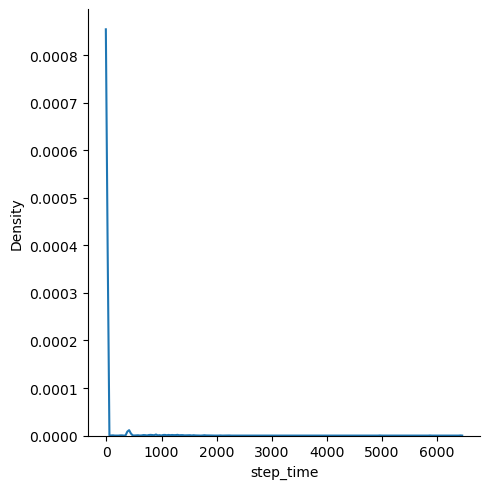

In [27]:
sns.displot(data['step_time'], kind='kde')

In [32]:
data['step_time'][data['model_version'].diff() == 1].max()

2933.613557233475